## Second principles: Fitting a mixture model to inferred 'true' values which is related to an observable with an uncertainty

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',20)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('axes',labelsize=15) 

import pandas as pd
import pystan

npts = 4000

def normal(x, mu, sigma):
    return (1/np.sqrt(2*np.pi*sigma**2)) * np.exp(-(x - mu)**2/(2*sigma**2))

Lets build our synthetic population no. 1

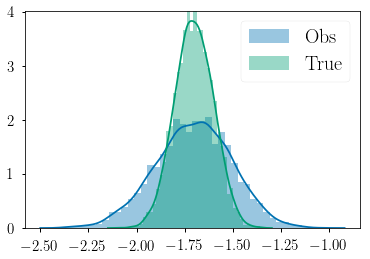

In [20]:
rQ = .95
rmu = -1.7
rsigma = .1
runc = 0.1

iM_true = np.random.randn(int(npts*rQ)) * rsigma + rmu
iunc = np.abs(runc * iM_true)
iM_obs = iM_true + np.random.randn(int(npts*rQ))*iunc

sns.distplot(iM_obs, label='Obs')
sns.distplot(iM_true, label='True')
plt.legend(fontsize=20)
plt.show()

Now synthetic population no. 2

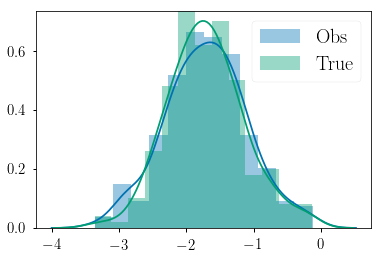

In [21]:
rmuo = rmu
rsigo = .6

oM_true = np.random.randn(int((1-rQ)*npts)) * rsigo + rmuo
ounc = np.abs(runc * oM_true) #uncertainties
oM_obs = oM_true + np.random.randn(int((1-rQ)*npts))*ounc

sns.distplot(oM_obs, label='Obs')
sns.distplot(oM_true, label='True')
plt.legend(fontsize=20)
plt.show()

Now lets combine them!

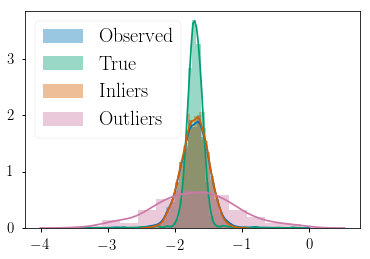

In [22]:
M_obs = np.append(oM_obs, iM_obs)
M_unc = np.append(ounc, iunc)
M_true = np.append(oM_true, iM_true)s
sns.distplot(M_obs, label='Observed')
sns.distplot(M_true, label='True')
sns.distplot(iM_obs, label='Inliers')
sns.distplot(oM_obs, label='Outliers')
plt.legend(fontsize=20)
plt.show()

Now I want to take M_obs and M_unc alone, and recover the 5 parameters (and maybe even the true magnitudes)

$p(\theta_{RC}, \{\alpha_i\} | \{\mathcal{D}_i\}) \propto p(\theta_{RC})\prod p(\mathcal{D}_i | \theta_{RC}, \alpha_i)p(\alpha_i | \theta_{RC})$

In [13]:
second = '''
data{
    int<lower=0> N;
    real Mobs[N];
    real Munc[N];
}
parameters {
    real mu;
    real<lower=0.> sigma;
    real<lower = 0., upper=1.> Q;
    real<lower=.3> sigo;
    
    real Mtrue_std[N];
}
transformed parameters {
    real Mtrue[N];
    real tsigo;
    
    for (n in 1:N){
        Mtrue[n] = mu + sigma*Mtrue_std[n];
    }
    tsigo = sigo/sigma;
}
model {
    mu ~ uniform(-1.9, -1.5); //p(theta)
    sigma ~ uniform(0.01, .3); //''
    sigo ~ uniform (.3, 3.); //''
    Q ~ uniform(0., 1.); //''

    Mobs ~ normal(Mtrue, Munc);  //p(D | theta, alpha)
    
    //p(alpha | theta)
    for (n in 1:N){
        target += log_mix(Q,
                    normal_lpdf(Mtrue_std[n] | 0, 1),
                    normal_lpdf(Mtrue_std[n] | 0, tsigo));
    }

}
'''
sm = pystan.StanModel(model_code=second)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_6b752d40509a4e6cb8891bd8f0bc7201 NOW.


In [23]:
data = {'N': len(M_true),
       'Mobs': M_obs,
       'Munc' : M_unc}
init = {'mu' : rmu,
       'sigma' : rsigma,
       'Q' : rQ,
       'sigo':rsigo}
fit = sm.sampling(data=data, iter=2000, chains=2, init=[init,init])

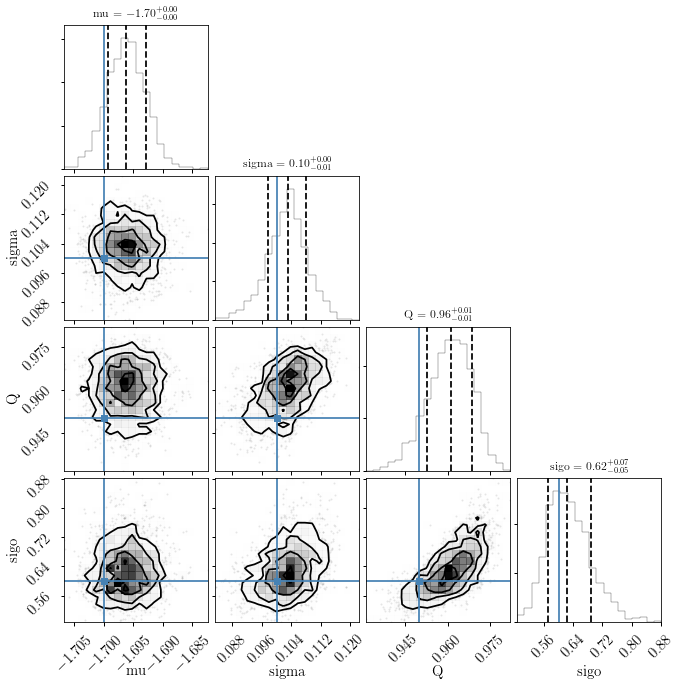

In [24]:
import corner
chain = np.array([fit['mu'],fit['sigma'],fit['Q'],fit['sigo']]).T
truths=[rmu, rsigma, rQ, rsigo]
corner.corner(chain,labels=['mu','sigma','Q','sigo'],\
                  truths=truths,\
                  quantiles=[0.16, 0.5, 0.84],\
                  show_titles=True, title_kwargs={"fontsize": 12})
plt.show()

In [ ]:
fit.plot()
plt.show()

In [26]:
mu = np.median(fit['mu'])
sigma = np.median(fit['sigma'])
sigo = (np.median(fit['sigo']))
Q = np.median(fit['Q'])

x = np.linspace(M_obs.min(), M_obs.max(), 1000)
fg = normal(x, mu, sigma)
bg = normal(x, mu, sigo)
L = Q*fg + (1-Q)*bg
rL = rQ * normal(x, rmu, rsigma) + (1-Q)*normal(x, rmu, rsigo)

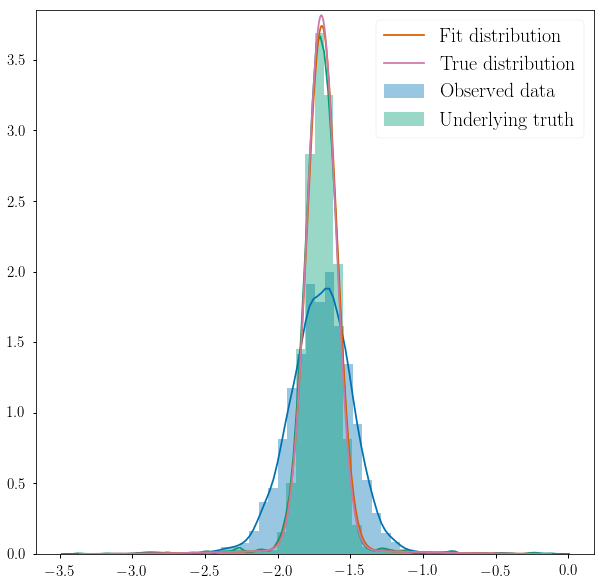

In [27]:
fig = plt.figure(figsize=(10,10))
sns.distplot(M_obs, label='Observed data')
sns.distplot(M_true, label='Underlying truth')
plt.plot(x, L, label='Fit distribution')
plt.plot(x, rL, label='True distribution')
plt.legend(fontsize=20)
plt.show()

In [28]:
print(fit)

Inference for Stan model: anon_model_6b752d40509a4e6cb8891bd8f0bc7201.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

                  mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu                -1.7  7.3e-5 3.3e-3   -1.7   -1.7   -1.7  -1.69  -1.69 2000.0    1.0
sigma              0.1  5.9e-4 5.5e-3   0.09    0.1    0.1   0.11   0.11   89.0   1.03
Q                 0.96  6.3e-4 7.8e-3   0.94   0.96   0.96   0.97   0.97  154.0   1.02
sigo              0.63  3.4e-3   0.06   0.53   0.59   0.62   0.67   0.77  318.0   1.01
Mtrue_std[0]      2.37    0.05   1.46   0.25   1.38   2.06   3.07   5.88 1050.0    1.0
Mtrue_std[1]      2.59    0.04   1.42   0.58   1.57   2.23   3.37    5.9 1230.0    1.0
Mtrue_std[2]      0.46    0.02   0.81  -1.06  -0.09   0.46   1.02   2.07 2000.0    1.0
Mtrue_std[3]     -1.77    0.09    2.1  -7.69  -2.13  -1.22  -0.56   0.69  526.0    1.0
Mtrue_std[4]     -0.24    0.

[1.00046094 1.0275009  1.01811572 ... 0.99951375 1.00070311 1.03779435]
Total number of Rhats: 8006
Total number of Rhats with the NaN values removed: 8006


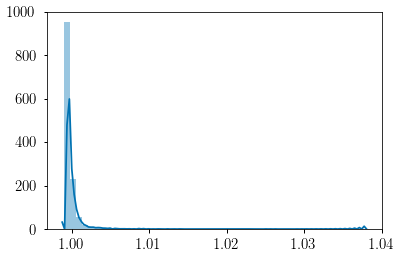

In [30]:
s = fit.summary()
print(s['summary'][:,-1])
rhat = s['summary'][:,-1]
rhatfin = rhat[np.isfinite(rhat)]
print('Total number of Rhats: '+str(len(rhat)))
print('Total number of Rhats with the NaN values removed: '+str(len(rhatfin)))
sns.distplot(rhatfin)
plt.show()